# theano简单计算
Theano的核心思想是用符号来定义数学表达式，并采用图的结构来对数学表达式进行建模。这一节将以简单的标量、向量、矩阵运算为例，介绍theano符号图的运作机制。


## 标量加法
让我们先来看一个简单的theano程序，这个程序实现了对任意两个浮点数求和的功能：

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import theano 
import theano.tensor as T
from theano import function
x = T.dscalar('x') 
y = T.dscalar('y')
z = x + y
f = function([x, y], z)
print np.allclose(f(1.5, 2.5), 4.0)


True


Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN not available)


上面的程序主要可以分为三个步骤：声明变量、符号表达式和编译函数
## 声明变量
声明计算图所要使用的符号以及它们的类型，程序通过`T.dscalar`声明了一个浮点类型的标量符号（以下统称变量），传入的字符串参数作为这个变量的名字。名字不是必须的，即未命名的变量，但是为了便于调试，最好在声明的时候为其命名。注意到`dscalar`并不是一个类，因此`x`和`y`都不是`dscalar`的实例，它们是TensorVariable类的实例对象，然而变量x的type域是`dscalar`类型。

In [2]:
print type(x)
print x.type
print T.dscalar
print x.type is T.dscalar

<class 'theano.tensor.var.TensorVariable'>
TensorType(float64, scalar)
TensorType(float64, scalar)
True


## 建立符号表达式  

```
z = x + y
```

`z`是另一个变量，它代表变量x，y的和。我们可以用`pp`函数(pretty-print)输出z的表达式：

In [3]:
from theano import pp
print type(z)
print pp(z)

<class 'theano.tensor.var.TensorVariable'>
(x + y)


## 编译函数
利用`function`函数将符号表达式编译为可供调用的C函数。function的第一个参数必须是一个变量的列表（即使只有一个变量），作为函数的输入；第二个参数可以是单个变量也可以是变量的列表，无论哪种情况，它都表示要求解的表达式的输出。

## eval函数

我们可以跳过步骤3，直接使用变量的eval()函数来计算表达式的值，它的好处是不必导入function，同时可以在调试过程中计算表达式的值。以下演示了eval()函数的用法

In [4]:
import theano.tensor as T
x = T.dscalar('x')
y = T.dscalar('y')
z = x + y
z.eval({x : 16.3, y : 12.1})

array(28.4)

我们给eval传入一个将符号映射到具体取值的字典，接着返回表达式的数值。eval()第一次使用会有些慢，因为它需要调用function()来编译表达式。后续对eval()的调用将变得很快，因为编译结果已经被缓存下来。

## 矩阵加法
只要将前面例子中x，y的类型改变为矩阵即可

In [5]:
x = T.dmatrix('x')
y = T.dmatrix('y')
z = x + y
f = function([x, y], z)

其中`dmatrix`表示浮点矩阵类型，调用新定义的函数计算两个矩阵的和：

In [6]:
f([[1, 2], [3, 4]], [[10, 20], [30, 40]])

array([[ 11.,  22.],
       [ 33.,  44.]])

我们也可以将numpy.array直接作为输入：

In [7]:
import numpy as np
f(np.array([[1, 2], [3, 4]]), np.array([[10, 20], [30, 40]]))

array([[ 11.,  22.],
       [ 33.,  44.]])

使用广播（broadcasting）技术，我们可以拓展标量与矩阵、向量与矩阵，标量与向量的运算，关于这部分内容，请移步[broadcasting in NumPy and Theano](http://deeplearning.net/software/theano/library/tensor/basic.html#broadcasting-in-theano-vs-numpy)

## 多个变量的情形
我们也可以用T.dscalars函数声明多个变量，完成多个变量的加法，我们还可以用In类给变量设定初始值

In [8]:
from theano import In
x, y, z = T.dscalars('x', 'y', 'z')
s = x + y + z
f = theano.function([x, In(y, value=1), In(z, value=2, name='z_by_name')], s)
print f(1)
print f(1, z_by_name=10)

4.0
12.0


注意到In类并不知道变量z的名字，因此在函数内为z定义了一个新名字，使得我们能够在调用函数时跳过y指定z的值。

## theano的Tensor类型
theano支持的张量类型总结如下：

* byte: bscalar, bvector, bmatrix, brow, bcol, btensor3, btensor4
* 16-bit integers: wscalar, wvector, wmatrix, wrow, wcol, wtensor3, wtensor4
* 32-bit integers: iscalar, ivector, imatrix, irow, icol, itensor3, itensor4
* 64-bit integers: lscalar, lvector, lmatrix, lrow, lcol, ltensor3, ltensor4
* float: fscalar, fvector, fmatrix, frow, fcol, ftensor3, ftensor4
* double: dscalar, dvector, dmatrix, drow, dcol, dtensor3, dtensor4
* complex: cscalar, cvector, cmatrix, crow, ccol, ctensor3, ctensor4


## 实现sigmoid函数
下面我们再来看一个sigmoid函数的例子。sigmoid函数是神经网络中最常用的激活函数之一，它的数学表达式定义为：  
$$ \sigma(x)=\frac{1}{1+\exp(-x)}$$

其中$x$既可以是一个标量也可以是一个向量（甚至矩阵），当它是向量时$\sigma(x)$相当于element-wise的sigmoid。  


[ 0.5         0.62245933  0.73105858  0.81757448]


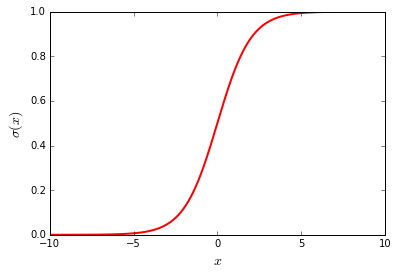

In [9]:
import theano.tensor as T
from theano import function
import numpy as np
import matplotlib.pyplot as plt
x = T.dvector('x')
s = 1 / (1 + T.exp(-x))
sigmoid = function([x], s)
print(sigmoid([0, 0.5, 1.0, 1.5]))
interval = np.linspace(-10, 10, 1000)
fig, ax = plt.subplots(1, 1)
ax.plot(interval, sigmoid(interval), 'r-', lw=2)
ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$\sigma(x)$', fontsize=14)
plt.show()

## 实现tanh函数
双曲正切函数（tanh）也是比较常用的激活函数，它的数学表达式定以为：
$$ tanh(x)=\frac{\exp(x)-\exp(-x)}{exp(x)+exp(-x)}$$
它与sigmoid函数的关系为
$$ \sigma(x)=\frac{1+tanh(x/2)}{2}$$

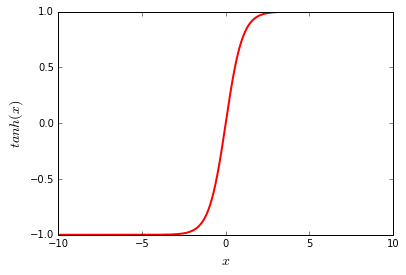

In [10]:
import theano.tensor as T
from theano import function
import numpy as np
import matplotlib.pyplot as plt
x = T.dvector('x')
s = (T.exp(x) - T.exp(-x)) / (T.exp(x) + T.exp(-x))
tanh = function([x], s)
interval = np.linspace(-10, 10, 1000)
fig, ax = plt.subplots(1, 1)
ax.plot(interval, tanh(interval), 'r-', lw=2)
ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$tanh(x)$', fontsize=14)
plt.show()

## 实现relu函数
relu函数定义为：
$$ relu(x)=\left\{\begin{aligned}x&\quad \mbox{if $x>0$}\\ 0 &\quad\mbox{if $x\leq 0$}\end{aligned}\right.$$

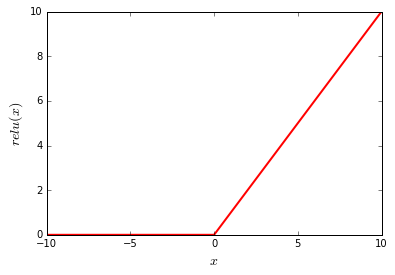

In [11]:
import theano.tensor as T
from theano import function
import numpy as np
import matplotlib.pyplot as plt
x = T.dvector('x')
s = T.switch(T.gt(x, 0), x, 0)
relu = function([x], s)
interval = np.linspace(-10, 10, 1000)
fig, ax = plt.subplots(1, 1)
ax.plot(interval, relu(interval), 'r-', lw=2)
ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$relu(x)$', fontsize=14)
plt.show()